In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torch
import random
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL

In [2]:
# settng data directory Config 

training_dir='./data/train'
test_dir='./data/test'
folder_database_train=datasets.ImageFolder(training_dir)
folder_database_test=datasets.ImageFolder(test_dir)

In [3]:
# Data Preprocessing
class CreateDataset(Dataset):
    def __init__(self,database,transform=None,should_invert=False):
        self.transform=transform
        self.database=database
        self.should_invert=should_invert   
        
    def __len__(self):
        return len(self.database.imgs)
        
    def __getitem__(self,idx):
        img_0=random.choice(self.database.imgs)
        
        same_class=random.randint(0,1)
        if same_class:
            while True:
                img_1=random.choice(self.database.imgs)
                if img_0[1]==img_1[1]:
                    break
        else:
            while True:
                img_1=random.choice(self.database.imgs)
                if img_0[1]!=img_1[1]:
                    break
                    
        img0=Image.open(img_0[0])
        img1=Image.open(img_1[0]) 
        img0=img0.convert("L")
        img1=img1.convert("L")
        label_0=img_0[1]
        label_1=img_1[1]
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        label_same=torch.from_numpy(np.array([int(label_0!=label_1)]))
        
        return img0,img1,label_same,label_0,label_1
        

In [4]:
# TransForms To be applied
transform=transforms.Compose([transforms.Resize((100,100)),
                              transforms.ToTensor()])

In [5]:
traindataset=CreateDataset(folder_database_train,transform=transform,should_invert=False)
trainLoader=DataLoader(traindataset,batch_size=32,shuffle=True)

In [6]:
tryLoader=DataLoader(traindataset,batch_size=8,shuffle=True)
batch=next(iter(tryLoader))
img0,img1,same,label0,label1=batch
print(img1.shape)
print(img0.shape)
print(same.shape)
print(label0.shape)

torch.Size([8, 1, 100, 100])
torch.Size([8, 1, 100, 100])
torch.Size([8, 1])
torch.Size([8])


In [7]:
device=device=torch.device("cuda" if torch.cuda.is_available() else "cpy")
print(device)

cuda


[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
labels:  22, 21, 25, 1, 25, 19, 23, 17, 

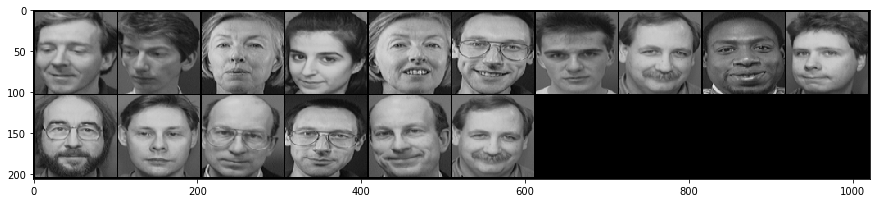

In [8]:
concatenated = torch.cat((img0,img1),0)
grid=torchvision.utils.make_grid(concatenated,nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(same.numpy())
print("labels: ", end=" ")
for i, label in enumerate(label0):
    print(label.item(), end=", ")

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork,self).__init__()
        
        self.cnn=nn.Sequential(
            nn.Conv2d(1,96,kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(3,stride=2),
            
            nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(3,stride=2),
            nn.Dropout2d(0.3),
            
            nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,stride=2),
            nn.Dropout2d(p=0.3),
            
            )
        self.fc=nn.Sequential(
            nn.Linear(25600,1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024,128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(128,2)
        )
        
    def forward_once(self,x):
        output=self.cnn(x)
        output=output.view(output.size()[0],-1)
        output=self.fc(output)
        return output
        
    def forward(self,input1,input2):
        output1= self.forward_once(input1)
        output2= self.forward_once(input2)

        return output1 ,output2
        
        

In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self,margin=2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin=margin=margin
        
    def forward(self,output1,output2,label):
        euclidean_distance=F.pairwise_distance(output1, output2)
        loss=torch.mean((1-label)*torch.pow(euclidean_distance,2)+
                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance,
                                                       min=0.0), 2))
        
        return loss
    

In [11]:
# initialize the model
model=SiameseNetwork().cuda()
criterion=ContrastiveLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0005)
model

SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_

In [12]:
losses=[]
counter=[]
iteration=0
epochs=100

In [13]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  112286 KB |  112286 KB |  112286 KB |       0 B  |\n|       from large pool |  111712 KB |  111712 KB |  111712 KB |       0 B  |\n|       from small pool |     574 KB |     574 KB |     574 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  112286 KB |  112286 KB |  112286 KB |       0 B  |\n|       from large pool |  111712 KB |  111712 KB |

In [14]:
# Training Iterations

torch.cuda.empty_cache()
for epoch in range(epochs):
    for i ,data in enumerate(trainLoader,0):
        img0,img1,same,label0,label1 =data
        if torch.cuda.is_available():
            img0,img1,same=img0.to(device),img1.to(device),same.to(device)
        optimizer.zero_grad()
        output1,output2=model(img0,img1)
        loss=criterion(output1,output2,same)
        loss.backward()
        optimizer.step()
        if i % 10:
            print("Epoch number {}\n Current loss {}\n".format(epoch,
                                                               loss.item()))
            iteration+=10
            counter.append(iteration)
            losses.append(loss.item())
                  

Epoch number 0
 Current loss 10.183865547180176

Epoch number 0
 Current loss 1.121767282485962

Epoch number 0
 Current loss 2.039088726043701

Epoch number 0
 Current loss 1.4343507289886475

Epoch number 0
 Current loss 1.2219421863555908

Epoch number 0
 Current loss 1.265268087387085

Epoch number 0
 Current loss 1.64921236038208

Epoch number 0
 Current loss 1.4925682544708252

Epoch number 0
 Current loss 1.1064221858978271

Epoch number 0
 Current loss 1.187188744544983

Epoch number 0
 Current loss 1.3625011444091797

Epoch number 1
 Current loss 1.265742301940918

Epoch number 1
 Current loss 1.1676424741744995

Epoch number 1
 Current loss 1.2041057348251343

Epoch number 1
 Current loss 1.0637755393981934

Epoch number 1
 Current loss 1.0688170194625854

Epoch number 1
 Current loss 1.3119056224822998

Epoch number 1
 Current loss 1.257810115814209

Epoch number 1
 Current loss 1.1799379587173462

Epoch number 1
 Current loss 1.3244189023971558

Epoch number 1
 Current loss


Epoch number 15
 Current loss 1.2699795961380005

Epoch number 15
 Current loss 1.197107195854187

Epoch number 15
 Current loss 1.2276551723480225

Epoch number 15
 Current loss 1.221805453300476

Epoch number 15
 Current loss 1.2198290824890137

Epoch number 15
 Current loss 1.3016936779022217

Epoch number 15
 Current loss 1.244349479675293

Epoch number 15
 Current loss 1.2598671913146973

Epoch number 15
 Current loss 1.2453855276107788

Epoch number 16
 Current loss 1.2008190155029297

Epoch number 16
 Current loss 1.2578864097595215

Epoch number 16
 Current loss 1.2998182773590088

Epoch number 16
 Current loss 0.9986820220947266

Epoch number 16
 Current loss 1.1766722202301025

Epoch number 16
 Current loss 1.0961257219314575

Epoch number 16
 Current loss 1.4144091606140137

Epoch number 16
 Current loss 0.7726619243621826

Epoch number 16
 Current loss 1.2924773693084717

Epoch number 16
 Current loss 1.3600752353668213

Epoch number 16
 Current loss 1.500550627708435

Epo


Epoch number 30
 Current loss 1.1916861534118652

Epoch number 30
 Current loss 1.276535987854004

Epoch number 30
 Current loss 1.3531162738800049

Epoch number 30
 Current loss 1.1853452920913696

Epoch number 30
 Current loss 1.2908918857574463

Epoch number 30
 Current loss 1.2684423923492432

Epoch number 30
 Current loss 1.2336480617523193

Epoch number 30
 Current loss 1.1605684757232666

Epoch number 30
 Current loss 1.2775765657424927

Epoch number 31
 Current loss 1.0309290885925293

Epoch number 31
 Current loss 1.3070849180221558

Epoch number 31
 Current loss 1.1756795644760132

Epoch number 31
 Current loss 1.1492342948913574

Epoch number 31
 Current loss 1.2808846235275269

Epoch number 31
 Current loss 1.3347368240356445

Epoch number 31
 Current loss 1.0658233165740967

Epoch number 31
 Current loss 1.3174465894699097

Epoch number 31
 Current loss 1.2504823207855225

Epoch number 31
 Current loss 1.150754690170288

Epoch number 31
 Current loss 1.0898003578186035

E


Epoch number 45
 Current loss 1.2641040086746216

Epoch number 45
 Current loss 1.2960872650146484

Epoch number 45
 Current loss 1.0572243928909302

Epoch number 45
 Current loss 1.3561885356903076

Epoch number 45
 Current loss 1.0892658233642578

Epoch number 45
 Current loss 1.1165169477462769

Epoch number 45
 Current loss 1.1753133535385132

Epoch number 45
 Current loss 1.2183864116668701

Epoch number 45
 Current loss 1.063637614250183

Epoch number 46
 Current loss 1.28330397605896

Epoch number 46
 Current loss 1.214713454246521

Epoch number 46
 Current loss 1.2474300861358643

Epoch number 46
 Current loss 1.2237968444824219

Epoch number 46
 Current loss 1.230582594871521

Epoch number 46
 Current loss 1.2764372825622559

Epoch number 46
 Current loss 1.2679919004440308

Epoch number 46
 Current loss 1.305541753768921

Epoch number 46
 Current loss 1.1411170959472656

Epoch number 46
 Current loss 1.1312931776046753

Epoch number 46
 Current loss 1.1195520162582397

Epoch


Epoch number 60
 Current loss 1.0892982482910156

Epoch number 60
 Current loss 1.2425320148468018

Epoch number 60
 Current loss 1.1865187883377075

Epoch number 60
 Current loss 1.2677785158157349

Epoch number 60
 Current loss 1.2152587175369263

Epoch number 60
 Current loss 1.0805593729019165

Epoch number 60
 Current loss 1.0605016946792603

Epoch number 60
 Current loss 1.0680688619613647

Epoch number 60
 Current loss 1.2931281328201294

Epoch number 61
 Current loss 1.3239729404449463

Epoch number 61
 Current loss 1.331899881362915

Epoch number 61
 Current loss 1.155771017074585

Epoch number 61
 Current loss 1.1026169061660767

Epoch number 61
 Current loss 1.176415205001831

Epoch number 61
 Current loss 1.0515179634094238

Epoch number 61
 Current loss 1.1990364789962769

Epoch number 61
 Current loss 1.1153091192245483

Epoch number 61
 Current loss 1.1275713443756104

Epoch number 61
 Current loss 1.2178704738616943

Epoch number 61
 Current loss 1.061702013015747

Epo


Epoch number 75
 Current loss 1.127990484237671

Epoch number 75
 Current loss 1.2331361770629883

Epoch number 75
 Current loss 1.342368245124817

Epoch number 75
 Current loss 1.2335585355758667

Epoch number 75
 Current loss 1.1318557262420654

Epoch number 75
 Current loss 1.224196195602417

Epoch number 75
 Current loss 1.1030040979385376

Epoch number 75
 Current loss 1.0923277139663696

Epoch number 75
 Current loss 1.4086841344833374

Epoch number 76
 Current loss 1.2569425106048584

Epoch number 76
 Current loss 1.139552116394043

Epoch number 76
 Current loss 1.5166258811950684

Epoch number 76
 Current loss 1.0779387950897217

Epoch number 76
 Current loss 1.2066173553466797

Epoch number 76
 Current loss 1.0907471179962158

Epoch number 76
 Current loss 1.0847816467285156

Epoch number 76
 Current loss 1.1377980709075928

Epoch number 76
 Current loss 1.3579808473587036

Epoch number 76
 Current loss 1.2593486309051514

Epoch number 76
 Current loss 1.161483883857727

Epoc


Epoch number 90
 Current loss 1.1794242858886719

Epoch number 90
 Current loss 1.2483117580413818

Epoch number 90
 Current loss 1.0575448274612427

Epoch number 90
 Current loss 1.2702455520629883

Epoch number 90
 Current loss 1.2854760885238647

Epoch number 90
 Current loss 1.3175153732299805

Epoch number 90
 Current loss 1.2293370962142944

Epoch number 90
 Current loss 1.282285213470459

Epoch number 90
 Current loss 1.0967711210250854

Epoch number 91
 Current loss 1.151887059211731

Epoch number 91
 Current loss 1.1278793811798096

Epoch number 91
 Current loss 1.183023452758789

Epoch number 91
 Current loss 1.2480400800704956

Epoch number 91
 Current loss 1.201279640197754

Epoch number 91
 Current loss 1.1658070087432861

Epoch number 91
 Current loss 1.238379955291748

Epoch number 91
 Current loss 1.4352374076843262

Epoch number 91
 Current loss 1.151292324066162

Epoch number 91
 Current loss 1.132054328918457

Epoch number 91
 Current loss 1.2146023511886597

Epoch 

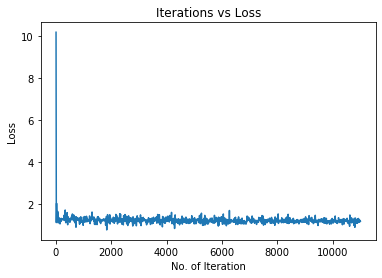

In [15]:
# Visualize Loss
plt.plot(counter,losses)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [33]:
# create Test Data set
testdataset=CreateDataset(folder_database_test,transform=transform)
testLoader=DataLoader(testdataset,batch_size=1,shuffle=True)

tensor([2])
{0: 0.14379142224788666, 2: 0.12498340010643005, 1: 0.6596276760101318}


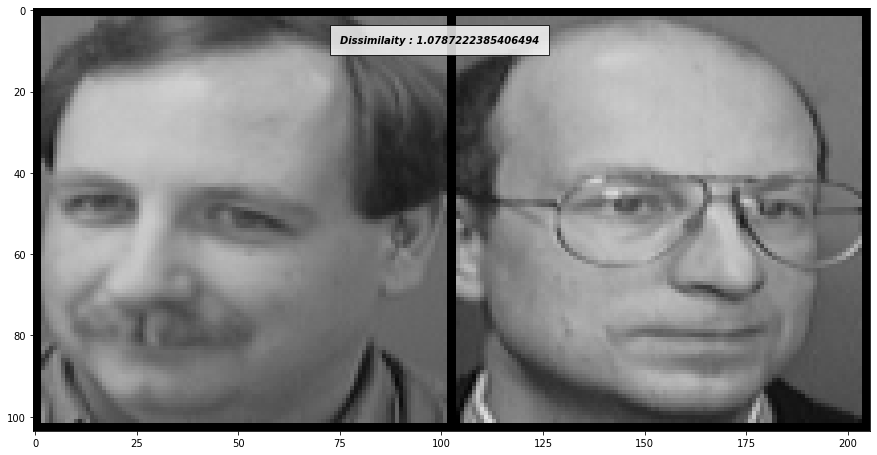

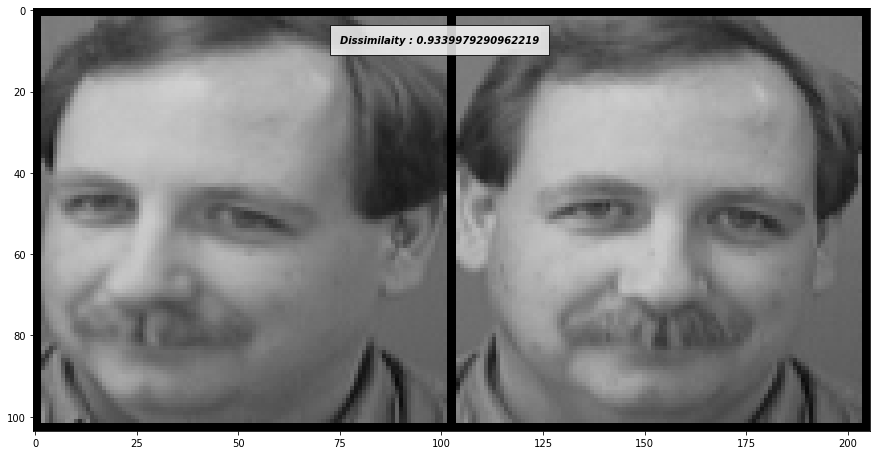

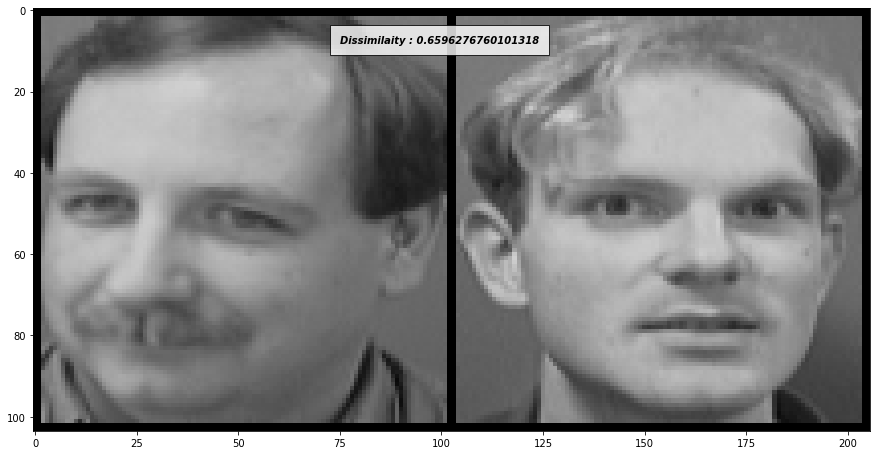

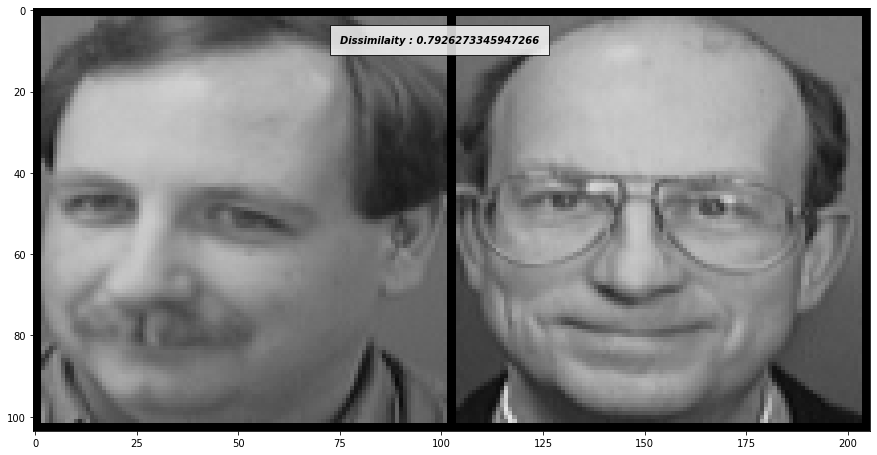

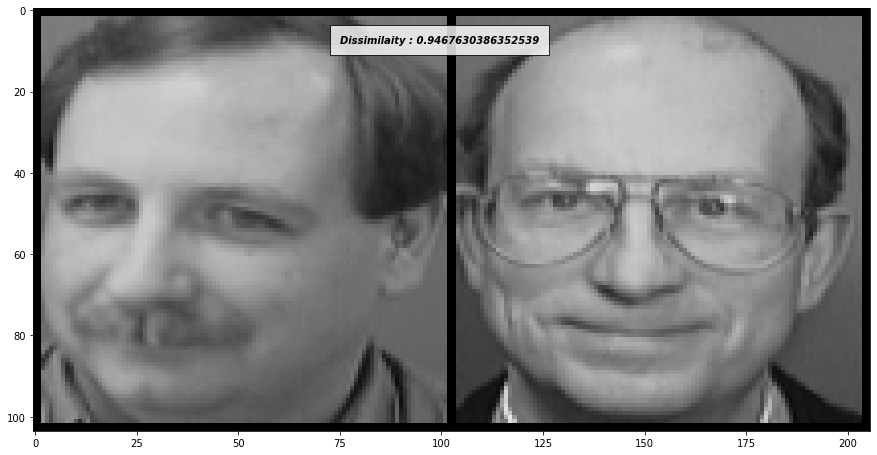

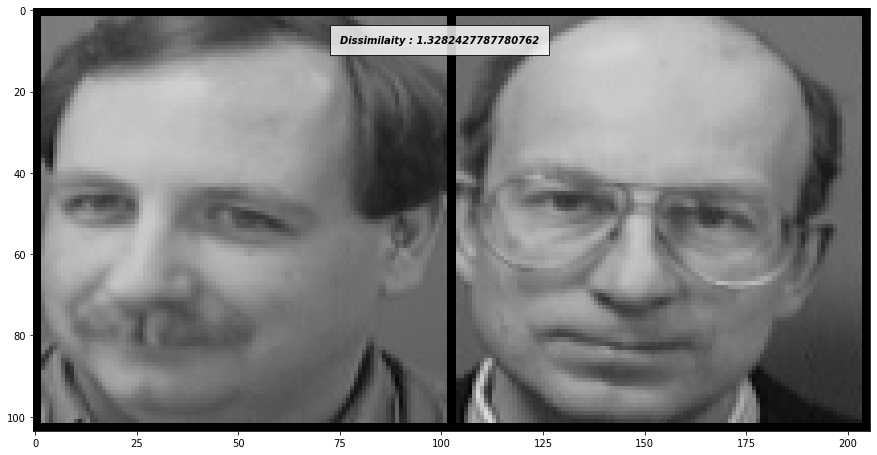

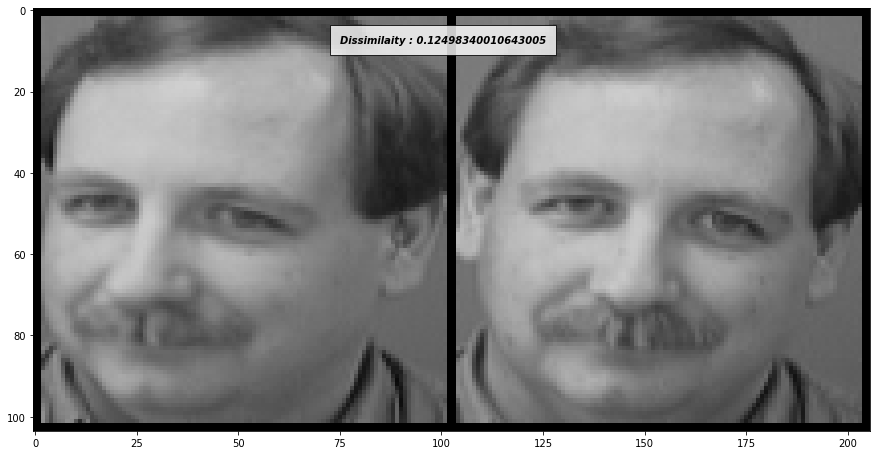

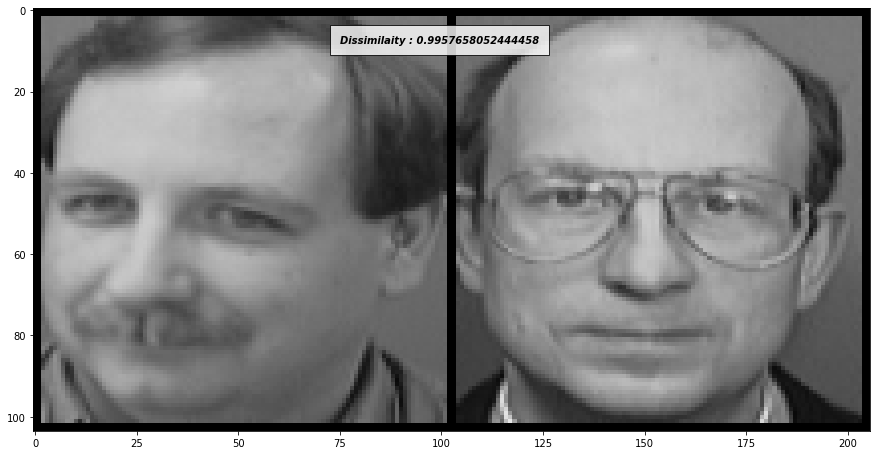

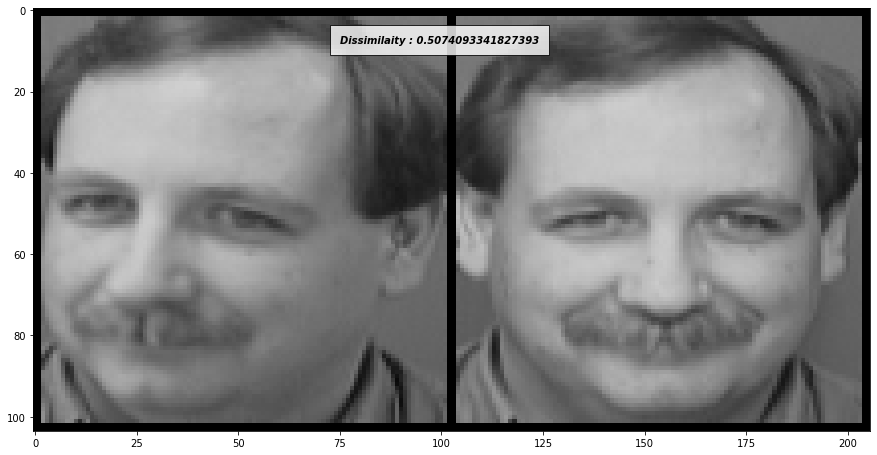

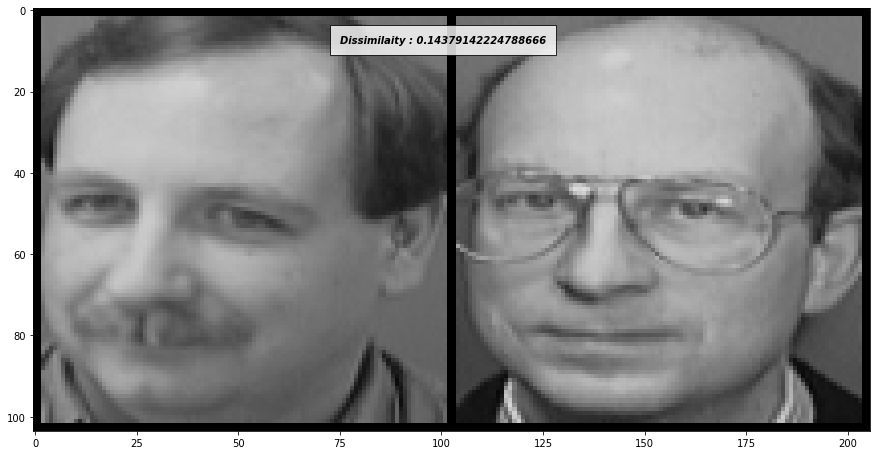

In [38]:
# Test on images

testbatch=next(iter(testLoader))
img1=testbatch[0]
person=testbatch[3]
similar={}

for i in range(10):
    batch=next(iter(testLoader))
    _,img2,_,_,label=batch

    concatenated=torch.cat((img1,img2),0)
    output1,output2=model(img1.to(device),img2.to(device))
    
    euclidean_distance=F.pairwise_distance(output1, output2)
    if label not in similar.keys():
        similar[label]=euclidean_distance.item()
    elif similar[label]>euclidean_distance.item():
        similar[label]=euclidean_distance.item()
    
    grid=torchvision.utils.make_grid(concatenated)
    plt.figure(figsize=(15, 20))
    text="Dissimilaity : {}".format(euclidean_distance.item())
    plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
print(person)
print(similar)


In [39]:
# Check Labels Prediction

k=sorted(list(similar.keys()),key=lambda x:similar[x])
print("Main Label: {}, Similar Label: {}".format(person.item(),k[0]))

Main Label: 2, Similar Label: 2
